In [162]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import tensorflow as tf
import os
import shutil
import datetime
import pickle
from tensorflow import keras
from matplotlib.image import imread

# Keras imports
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.utils import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalMaxPooling2D, Dropout
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
plt.rcParams.update({'font.size': 22})

rand_seed = 69
tf.keras.utils.set_random_seed(rand_seed)
np.random.seed(rand_seed)

In [163]:
# Dataset Location
base_folder = "datasets"
train_set = os.path.join(base_folder, "train")
val_set = os.path.join(base_folder, "val")
test_set = os.path.join(base_folder, "test")

# Define size
im_width = 224
im_height = 224
im_size = (im_width, im_height)
im_channels = 3
input_dim = (im_width, im_height, im_channels)
im_size_cifar = (32, 32)
input_dim_cifar = (*im_size_cifar, 3)

# Config
loss_function = 'binary_crossentropy' # Since we only have 2 classes
loss_function_cifar = 'categorical_crossentropy'
opt = keras.optimizers.SGD
metrics = ['accuracy']
log_dir = f"logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
earlystop = EarlyStopping(patience=15)
tb = TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint = ModelCheckpoint(filepath = "checkpoint/model.h5",
                             monitor='val_accuracy',
                             mode = 'max',
                             save_best_only=True)
checkpoint_cifar = ModelCheckpoint(filepath = "checkpoint/modelcifar.h5",
                                   monitor='val_accuracy',
                                   mode = 'max',
                                   save_best_only=True)
checkpoint_cifar2 = ModelCheckpoint(filepath = "checkpoint/modelcifar2.h5",
                                   monitor='val_accuracy',
                                   mode = 'max',
                                   save_best_only=True)
callbacks = [earlystop, checkpoint]
callbacks_cifar = [earlystop, checkpoint_cifar]
callbacks_cifar2 = [earlystop, checkpoint_cifar2]
batch_size = 64
epochs = 10
lr = 0.001
momentum = 0.9

# Transforms
transforms = {
    "rescale": 1.0/255.0,
    "horizontal_flip": True,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
    "rotation_range": 15,
    "shear_range": 0.2,
    "zoom_range": 0.2,
    "fill_mode": "nearest",
}
transforms_cifar = {
    "horizontal_flip": True,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
}

In [54]:
# Label the test data

# Check if labels file exists
override = 0
if not os.path.exists(test_set + "/labels.csv") or override:
    files = sorted(os.listdir(test_set))
    filenames = [file.split('.')[0] for file in files if ".jpg" in file]
    filenames_sorted = [file + '.jpg' for file in sorted(filenames, key = lambda x: int(x))]
    data = {
        "filename": filenames_sorted,
        "category": [0 for _ in filenames_sorted]
    }
    test_df = pd.DataFrame(data=data)
    test_df.to_csv(test_set + "/labels.csv")
    print("Created new labels file.")
    
# Check if images are partitioned
files = os.listdir(test_set)
override2 = 0
if "cat" not in files or override2:
    print("Moving files")
    label_dirs = ["cat", "dog"]
    for d in label_dirs:
#         os.makedirs(os.path.join(test_set, d))
        pass
    
    # Read in labels
    labels = pd.read_csv(test_set + "/labels.csv")
    cats = 0
    dogs = 0
    for i in labels.itertuples():
        src = os.path.join(test_set, i.filename)
        dest = os.path.join(test_set, label_dirs[i.category], i.filename)
        if i.category == 0:
            cats += 1
        else:
            dogs += 1
#         shutil.move(src, dest)
        
    print(f"Total cats: {cats}. Total dogs: {dogs}")

Moving files
Total cats: 243. Total dogs: 257


<Figure size 864x864 with 0 Axes>

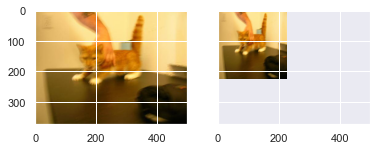

In [55]:
cat = load_img('./datasets/train/cat/cat.0.jpg')
cat2 = load_img('./datasets/train/cat/cat.0.jpg', target_size = input_dim)
plt.figure(figsize=(12,12))
f, ax = plt.subplots(1,2, sharex=True, sharey=True)

ax[1].imshow(cat2)
ax[0].imshow(cat)
plt.savefig("catscaled.png", dpi=120, bbox_inches='tight')

In [3]:
# define cnn model
def define_modelexample():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = 'SGD'
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [57]:
modelexample = define_modelexample()
modelexample.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 401408)            0         
                                                                 
 dense_8 (Dense)             (None, 128)               51380352  
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 51,381,377
Trainable params: 51,381,377
Non-trainable params: 0
__________________________________________

In [58]:
# Model option 3
def create_model3():
    model = VGG16(include_top=False, input_shape=input_dim, weights="imagenet")
    # Mark layers as not trainable
    for layer in model.layers[:15]:
        layer.trainable = False
    for layer in model.layers[15:]:
        layer.trainable = True
        
    # Add classifier layers
    flat1 = GlobalMaxPooling2D()(model.layers[-1].output)
    class1 = Dense(512, activation='relu', kernel_initializer='he_uniform')(flat1)
    dropout = Dropout(0.5)(class1)
    output = Dense(1, activation='sigmoid')(dropout)
    
    # Define a new model
    model = Model(inputs=model.inputs, outputs=output)
    
    # Compile
    model.compile(optimizer=opt(learning_rate=lr, momentum=momentum), loss=loss_function, metrics=metrics)
    
    return model


In [233]:
model = create_model3()
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [8]:
# Generate train data with transforms
train_data_gen = ImageDataGenerator(**transforms)
val_data_gen = ImageDataGenerator(rescale=1./255.0)

# Iterators
trainer = train_data_gen.flow_from_directory(
    train_set, class_mode='binary',
    batch_size=batch_size, 
    target_size=im_size
)
validator = val_data_gen.flow_from_directory(val_set, class_mode='binary',
                                             batch_size=batch_size, target_size=im_size)

# Test set

# Load filenames and labels
def mapper(x):
    val = {0: "cat", 1: "dog"}
    return val[x]
test_df = pd.read_csv(os.path.join(test_set, "labels.csv"))
test_df['category'] = test_df['category'].apply(lambda x: str(x))
    
tester = val_data_gen.flow_from_dataframe(test_df, directory=test_set, x_col='filename', y_col='category',
                                          class_mode=None, batch_size=batch_size, target_size=im_size, shuffle=False)
print(test_x.shape)
print(test_y.shape)
print(len(trainer))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 500 validated image filenames.
(10000, 32, 32, 3)
(10000, 10)
313


Found 1 images belonging to 1 classes.


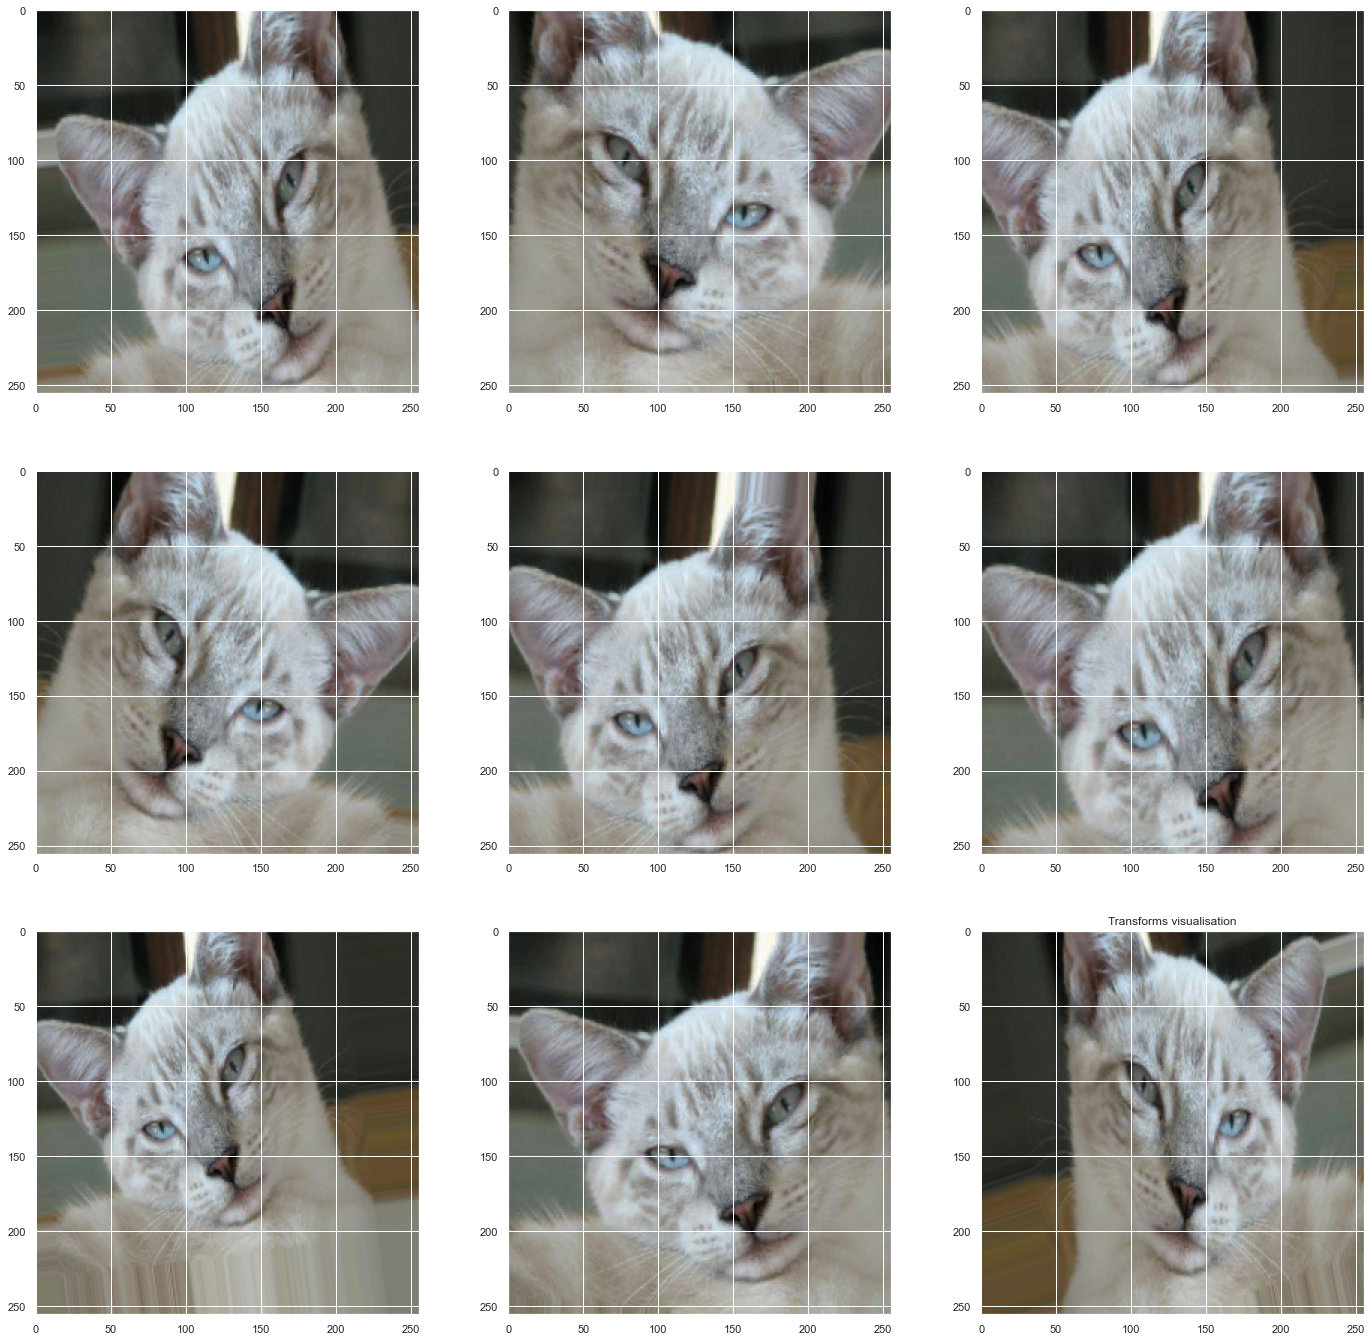

In [60]:
# Visualise transforms

plt.figure(figsize=(24,24))
example_directory = "datasets/example/cat"
example_image_file = "datasets/train/cat/cat.69.jpg"
if not os.path.exists(example_directory):
    os.makedirs(example_directory)
shutil.copy2(example_image_file, example_directory)
transform_keys = [k for k, _ in transforms.items()]

exampler = train_data_gen.flow_from_directory("datasets/example", class_mode='binary')
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    for img, _ in exampler:
        plt.imshow(img[0])
        break
plt.title("Transforms visualisation")
plt.show()

In [52]:
# Fit model
with tf.device('/device:GPU:0'):
    history = model.fit(trainer, steps_per_epoch=len(trainer),
                        validation_data=validator, validation_steps=len(validator),
                        epochs=epochs, verbose=1, callbacks=callbacks)

Epoch 1/10
313/313 [==============================] - 544s 2s/step - loss: 0.2583 - accuracy: 0.8849 - val_loss: 0.1109 - val_accuracy: 0.9580
Epoch 2/10
313/313 [==============================] - 588s 2s/step - loss: 0.1366 - accuracy: 0.9442 - val_loss: 0.1075 - val_accuracy: 0.9578
Epoch 3/10
313/313 [==============================] - 553s 2s/step - loss: 0.1094 - accuracy: 0.9555 - val_loss: 0.0818 - val_accuracy: 0.9686
Epoch 4/10
313/313 [==============================] - 557s 2s/step - loss: 0.0989 - accuracy: 0.9598 - val_loss: 0.0833 - val_accuracy: 0.9666
Epoch 5/10
313/313 [==============================] - 560s 2s/step - loss: 0.0827 - accuracy: 0.9673 - val_loss: 0.0717 - val_accuracy: 0.9752
Epoch 6/10
313/313 [==============================] - 563s 2s/step - loss: 0.0741 - accuracy: 0.9700 - val_loss: 0.0670 - val_accuracy: 0.9744
Epoch 7/10
313/313 [==============================] - 562s 2s/step - loss: 0.0688 - accuracy: 0.9723 - val_loss: 0.0650 - val_accuracy: 0.9772

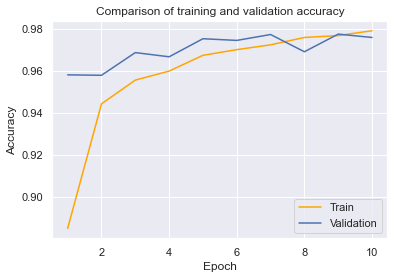

In [61]:
acc_list = [0.8849, 0.9442, 0.9555, 0.9598, 0.9673, 0.9700, 0.9723, 0.9758, 0.9767, 0.9790]
acc_list_val = [0.9580, 0.9578, 0.9686, 0.9666, 0.9752, 0.9744, 0.9772, 0.9690, 0.9774, 0.9758]

epochs = [_ for _ in range(1,11)]
plt.plot(epochs, acc_list, 'orange')
plt.plot(epochs, acc_list_val, 'b')
plt.legend(["Train", "Validation"])
plt.title("Comparison of training and validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig("catdogacc.png", dpi=120, bbox_inches='tight')
plt.show()


8/8 [==============================] - 6s 885ms/step


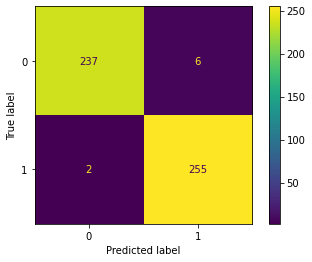

Accuracy: 0.984
Precision: 0.9916317991631799
Recall: 0.9753086419753086
F1: 0.9834024896265561
Specificity: 0.9922178988326849


In [77]:
# Prediction
pred = model.predict(tester, verbose=1)
pred = np.where(pred > 0.5, "1", "0")

# Calculate metrics
correct = 0
tp = fp = fn = tn = 0
for predicted, actual in zip(pred, test_y):
    if predicted[0] == "0" and actual == "0":
        tp +=1
    elif predicted[0] == "0" and actual == "1":
        fp +=1
    elif predicted[0] == "1" and actual == "0":
        fn += 1
    else:
        tn += 1
        
acc = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = (2*precision*recall)/(precision + recall)
specificity = tn/(tn+fp)

cm = ConfusionMatrixDisplay.from_predictions(test_y, pred)
plt.show()
print(f"Accuracy: {acc}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\nSpecificity: {specificity}")

In [71]:
# Save result
filenames = []
pred_category = []

result_df = pd.DataFrame(data= {
    "id": test_df['filename'],
    "label": [val[0] for val in pred]
})

result_df.to_csv("CatsDogsResult.csv")

# Cifar10

In [19]:
# Load dataset
(train_x, train_y), (test_x, test_y) = cifar10.load_data()
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, random_state=69, test_size=0.2, stratify=train_y)
print(np.unique(train_y, return_counts=True), np.unique(val_y, return_counts=True))
train_y = keras.utils.to_categorical(train_y)
val_y = keras.utils.to_categorical(val_y)
test_y = keras.utils.to_categorical(test_y)

print("Initial Load:")
print('Train Initial: X=%s, y=%s' % (train_x.shape, train_y.shape))
print('Test Initial: X=%s, y=%s\n' % (test_x.shape, test_y.shape))


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000])) (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))
Initial Load:
Train Initial: X=(40000, 32, 32, 3), y=(40000, 10)
Test Initial: X=(10000, 32, 32, 3), y=(10000, 10)



In [20]:
# Prepare Data
def cifar_preprocess(train, val, test):
    train_norm = train.astype('float32') / 255.0
    val_norm = val.astype('float32') / 255.0
    test_norm = test.astype('float32') / 255.0
     
    return train_norm, val_norm, test_norm
    
train_x, val_x, test_x = cifar_preprocess(train_x, val_x, test_x)

# Image Augmentation on train
cifar_train_gen = ImageDataGenerator(**transforms_cifar)
cifar_train = cifar_train_gen.flow(train_x, train_y, batch_size=batch_size)
print(len(cifar_train))


625


In [174]:
# Prepare model

def create_model_cifar():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    # compile model
    model.compile(optimizer=opt(learning_rate=lr, momentum=momentum), loss=loss_function_cifar, metrics=metrics)
    
    return model

from keras.applications.vgg16 import VGG16
from keras.models import Model

def create_model_cifar2():
    model = VGG16(include_top=False, input_shape=input_dim_cifar, weights="imagenet")
    # Mark layers as not trainable
    for layer in model.layers[:15]:
        layer.trainable = False
    for layer in model.layers[15:]:
        layer.trainable = True
        
    # Add classifier layers
    flat1 = GlobalMaxPooling2D()(model.layers[-1].output)
    class1 = Dense(512, activation='relu', kernel_initializer='he_uniform')(flat1)
    dropout = Dropout(0.5)(class1)
    output = Dense(10, activation='softmax')(dropout)
    
    # Define a new model
    model = Model(inputs=model.inputs, outputs=output)
    
    # Compile
    model.compile(optimizer=opt(learning_rate=lr, momentum=momentum), loss=loss_function_cifar, metrics=metrics)
    
    return model

model_cifar = create_model_cifar2()
model_cifar.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [22]:
# Train
with tf.device('/device:GPU:0'):
    history = model_cifar.fit(cifar_train, validation_data=(val_x, val_y), batch_size=batch_size,
                              epochs=50, verbose=1, callbacks=callbacks_cifar)

Epoch 1/50
625/625 [==============================] - 24s 38ms/step - loss: 1.4482 - accuracy: 0.4869 - val_loss: 0.9789 - val_accuracy: 0.6549
Epoch 2/50
625/625 [==============================] - 24s 38ms/step - loss: 1.0696 - accuracy: 0.6263 - val_loss: 0.9888 - val_accuracy: 0.6460
Epoch 3/50
625/625 [==============================] - 24s 38ms/step - loss: 0.9666 - accuracy: 0.6664 - val_loss: 0.8635 - val_accuracy: 0.6973
Epoch 4/50
625/625 [==============================] - 27s 43ms/step - loss: 0.9094 - accuracy: 0.6829 - val_loss: 0.8111 - val_accuracy: 0.7151
Epoch 5/50
625/625 [==============================] - 37s 60ms/step - loss: 0.8577 - accuracy: 0.7000 - val_loss: 0.8093 - val_accuracy: 0.7139
Epoch 6/50
625/625 [==============================] - 46s 73ms/step - loss: 0.8225 - accuracy: 0.7128 - val_loss: 0.7968 - val_accuracy: 0.7215
Epoch 7/50
625/625 [==============================] - 44s 71ms/step - loss: 0.7887 - accuracy: 0.7228 - val_loss: 0.7884 - val_accuracy:

In [23]:
# Save history
with open("./checkpoint/cifar_history.pickle", 'wb') as f:
    pickle.dump(history.history, f)
    
model_load = False
if model_load:
    model = keras.models.load_model("checkpoint/modelcifar.h5")

# Predict
result = model_cifar.evaluate(test_x, test_y, verbose=1)

313/313 [==============================] - 5s 16ms/step - loss: 0.8208 - accuracy: 0.7531


<Figure size 1600x900 with 0 Axes>

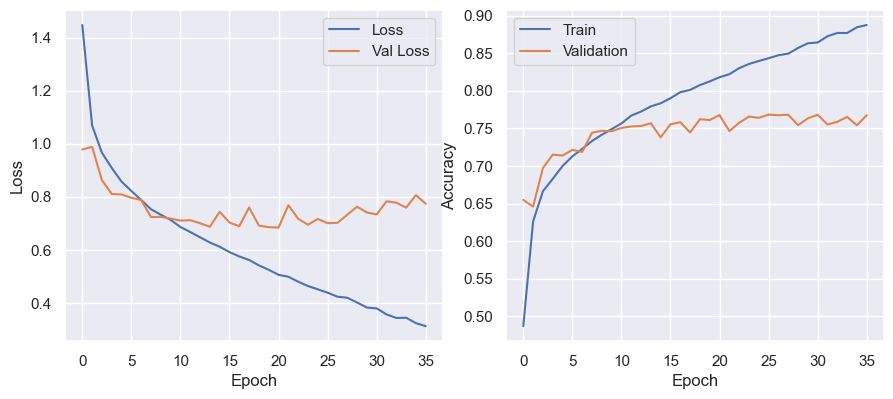

In [60]:
%matplotlib inline
import seaborn as sb
sb.set()

# Plot history
plt.figure(figsize=(16,9))
f, ax = plt.subplots(1,2)
f.set_size_inches(9, 4)
f.tight_layout()
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set(xlabel="Epoch", ylabel="Loss")
ax[0].legend(["Loss", "Val Loss"])
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set(xlabel="Epoch", ylabel="Accuracy")
ax[1].legend(["Train", "Validation"])
plt.savefig("cifarmetrics.png", dpi=120, bbox_inches='tight')
plt.show()

# Cifar10 Unbalanced

,img_arr,label
0,"[[[59, 62, 63], [43, 46, 45], [50, 48, 43], [6...",6
1,"[[[154, 177, 187], [126, 137, 136], [105, 104,...",9
2,"[[[255, 255, 255], [253, 253, 253], [253, 253,...",9
3,"[[[28, 25, 10], [37, 34, 19], [38, 35, 20], [4...",4
4,"[[[170, 180, 198], [168, 178, 196], [177, 185,...",1
...,...,...
49995,"[[[145, 161, 194], [151, 166, 199], [156, 171,...",2
49996,"[[[255, 245, 132], [254, 247, 134], [255, 249,...",6
49997,"[[[35, 178, 235], [40, 176, 239], [42, 176, 24...",9
49998,"[[[189, 211, 240], [186, 208, 236], [185, 207,...",1


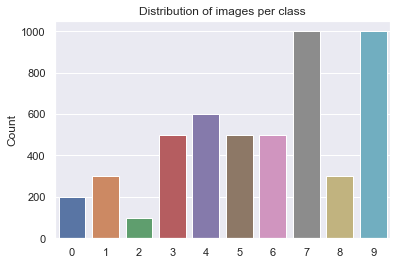

In [180]:
# Load dataset
(train_x, train_y), (test_x, test_y) = cifar10.load_data()
splits = [200,300,100,500,600,500,500,1000,300,1000] # Partition unevenly. Total = 5000

class_split = {i:[count] for i, count in enumerate(splits)}
cifar_unbalanced = pd.DataFrame.from_dict(class_split, orient='index', columns=["Count"])
bar=sb.barplot(data=cifar_unbalanced, x=cifar_unbalanced.index, y=cifar_unbalanced["Count"])\
               .set(title="Distribution of images per class")

# Actually split the data
splits_train = list(map(lambda x: x*4, splits)) # Total = 20000
train_x = [i for i in train_x]
train_y = [i[0] for i in train_y]

# Convert data into df
cifar_df = pd.DataFrame(data={"img_arr": train_x, "label": train_y})
cifar_df

In [184]:
train_dict = {}
val_dict = dict()
new_train_df = pd.DataFrame()
new_val_df = pd.DataFrame()

for i in range(10):
    # Partition for each class label
    data = cifar_df.loc[cifar_df['label']==i]
    val_data = data[:splits[i]]
    train_data = data[splits[i]:splits[i]+splits_train[i]]
    new_train_df = new_train_df.append(train_data)
    new_val_df = new_val_df.append(val_data)
    
# Convert back to np array
train_list = []
val_list = []
new_train_x = np.array([i for i in new_train_df.to_numpy()[:,0]])
new_train_y = np.array([i for i in new_train_df.to_numpy()[:,1]])
new_val_x = np.array([i for i in new_val_df.to_numpy()[:,0]])
new_val_y = np.array([i for i in new_val_df.to_numpy()[:,1]])

new_train_y = keras.utils.to_categorical(new_train_y)
new_val_y = keras.utils.to_categorical(new_val_y)
test_y = keras.utils.to_categorical(test_y)
print(new_val_y.shape)

(5000, 10)


In [185]:
# Prepare Data
def cifar_preprocess(train, val, test):
    train_norm = train.astype('float32') / 255.0
    val_norm = val.astype('float32') / 255.0
    test_norm = test.astype('float32') / 255.0
     
    return train_norm, val_norm, test_norm
    
new_train_x, new_val_x, test_x = cifar_preprocess(new_train_x, new_val_x, test_x)

# Image Augmentation on train
cifar_train_gen = ImageDataGenerator(**transforms_cifar)
cifar_train = cifar_train_gen.flow(new_train_x, new_train_y, batch_size=batch_size)
print(len(cifar_train))

313


In [176]:
# Load Model
model_cifar = create_model_cifar2()
# model_cifar.summary()

# Train
with tf.device('/device:GPU:0'):
    history = model_cifar.fit(cifar_train, validation_data=(new_val_x, new_val_y), batch_size=batch_size,
                              epochs=50, verbose=1, callbacks=callbacks_cifar2)

Epoch 1/50
313/313 [==============================] - 14s 44ms/step - loss: 1.5029 - accuracy: 0.4840 - val_loss: 1.0779 - val_accuracy: 0.6238
Epoch 2/50
313/313 [==============================] - 13s 41ms/step - loss: 1.1113 - accuracy: 0.6175 - val_loss: 0.9679 - val_accuracy: 0.6674
Epoch 3/50
313/313 [==============================] - 13s 40ms/step - loss: 0.9957 - accuracy: 0.6546 - val_loss: 0.9419 - val_accuracy: 0.6762
Epoch 4/50
313/313 [==============================] - 13s 42ms/step - loss: 0.9371 - accuracy: 0.6756 - val_loss: 0.8118 - val_accuracy: 0.7224
Epoch 5/50
313/313 [==============================] - 13s 42ms/step - loss: 0.8753 - accuracy: 0.6944 - val_loss: 0.8159 - val_accuracy: 0.7132
Epoch 6/50
313/313 [==============================] - 14s 44ms/step - loss: 0.8323 - accuracy: 0.7119 - val_loss: 0.7664 - val_accuracy: 0.7328
Epoch 7/50
313/313 [==============================] - 13s 40ms/step - loss: 0.8006 - accuracy: 0.7203 - val_loss: 0.8008 - val_accuracy:

In [186]:
# Save history
with open("./checkpoint/cifar_uneven_history.pickle", 'wb') as f:
    pickle.dump(history.history, f)
    
model_load = False
if model_load:
    model = keras.models.load_model("checkpoint/modelcifar.h5")

# Predict
result = model_cifar.evaluate(test_x, test_y, verbose=1)

313/313 [==============================] - 5s 15ms/step - loss: 1.0965 - accuracy: 0.6870


<Figure size 1152x648 with 0 Axes>

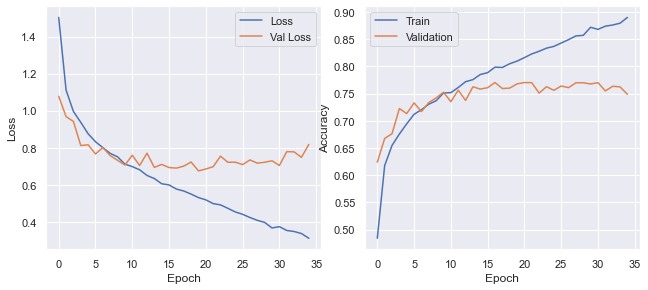

In [182]:
# Plot history
plt.figure(figsize=(16,9))
f, ax = plt.subplots(1,2)
f.set_size_inches(9, 4)
f.tight_layout()
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set(xlabel="Epoch", ylabel="Loss")
ax[0].legend(["Loss", "Val Loss"])
ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set(xlabel="Epoch", ylabel="Accuracy")
ax[1].legend(["Train", "Validation"])
plt.savefig("cifaruneven.png", dpi=120)